<a href="https://colab.research.google.com/github/jeongminia/Cancer-Classification/blob/main/weekly/week6/1017_CatBoost_jm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 암환자 유전체 데이터 기반 암종 분류 AI 모델 개발
https://github.com/jeongminia/Cancer-Classification/blob/main/weekly/week1/0910_oyi.ipynb


# library loading

In [1]:
import re
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
from sklearn.metrics import f1_score

# macro f1 score 함수
def macro_f1_score(y_true, y_pred, n_classes = 26):
    f1_scores = []
    for c in range(n_classes):
        y_true_c = (y_true == c)
        y_pred_c = (y_pred == c)
        f1_c = f1_score(y_true_c, y_pred_c)
        f1_scores.append(f1_c)
    return np.mean(f1_scores)

In [3]:
!git clone https://github.com/jeongminia/Cancer-Classification.git

Cloning into 'Cancer-Classification'...
remote: Enumerating objects: 283, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 283 (delta 81), reused 21 (delta 21), pack-reused 165 (from 1)
Receiving objects: 100% (283/283), 12.37 MiB | 5.62 MiB/s, done.
Resolving deltas: 100% (137/137), done.
Updating files: 100% (37/37), done.


In [4]:
!unzip -qq '/content/Cancer-Classification/data/open.zip'

In [5]:
!unzip -qq '/content/Cancer-Classification/data/preprocessed_data.zip'

# data loading

In [36]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [37]:
train.tail(5)

,ID,SUBCLASS,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
6196,TRAIN_6196,LUAD,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
6197,TRAIN_6197,LGG,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
6198,TRAIN_6198,COAD,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,T181S,WT
6199,TRAIN_6199,TGCT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
6200,TRAIN_6200,SKCM,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT


In [38]:
test.head(5)

,ID,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,ABCA4,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
0,TEST_0000,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
1,TEST_0001,WT,WT,WT,WT,WT,R587Q,WT,WT,WT,...,WT,WT,WT,WT,WT,I383Sfs,WT,WT,WT,WT
2,TEST_0002,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
3,TEST_0003,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
4,TEST_0004,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT


In [39]:
len(train), len(test)

(6201, 2546)

# preprocessing

1. 결측값 처리
2. 아미노산 변이 치환
  - WT(정상)
  - missense ← 알파벳숫자**알파벳** (치환)
  - insertion ← **-**숫자알파벳 or 알파벳숫자**ins** (삽입)
  - deletion ← 알파벳숫자**del** (삭제)
  - delins ← 알파벳숫자**delins**알파벳 (집단치환)
  - frameshift ← 알파벳숫자**fs**
  - nonsense ← 알파벳숫자 * (조기종결)

  2.1. category1
  
  2.2. category2

  2.3. category3

3. column WT 차원축소
4. 파생변수 생성 mutation_cnt
5. Custom Numeric Encoding
6. Subclass_encoding

### 결측값 처리

In [40]:
# NaN 개수와 위치 확인
train_nan = train.isna().sum().sum()
train_nan_columns = train.columns[train.isna().any()].tolist()
print(f"train NaN 개수: {train_nan}")
print("NaN 값이 있는 열:")
print(train_nan_columns)

test_nan = test.isna().sum().sum()
test_nan_columns = test.columns[test.isna().any()].tolist()
print(f"test NaN 개수: {test_nan}")
print("NaN 값이 있는 열:")
print(test_nan_columns)

train NaN 개수: 0
NaN 값이 있는 열:
[]
test NaN 개수: 237
NaN 값이 있는 열:
['AK2', 'ATP6V1H', 'CCRL2', 'CFP', 'CNOT2', 'CRAT', 'DPYSL4', 'GUK1', 'IER3', 'INHBB', 'KCNH1', 'MYL1', 'NDUFV1', 'NUDT4', 'POLD2', 'PTCH1', 'PTGES3', 'RBM5', 'SCAMP1', 'SCNN1A', 'SLC25A28', 'SYBU', 'TARS1', 'TMEM97', 'TNFAIP6']


In [41]:
# NaN 값을 'WT'로 치환
train.fillna('WT', inplace=True)
test.fillna('WT', inplace=True)

print()

train_nan = train.isna().sum().sum()
print(f"처리 후 train NaN 개수: {train_nan}")

test_nan = test.isna().sum().sum()
print(f"처리 후 test NaN 개수: {test_nan}")


처리 후 train NaN 개수: 0
처리 후 test NaN 개수: 0


### 아미노산 변이 치환

#### 1. category1

In [42]:
def process_value1(value):
    # 1) WT 그대로 유지
    if value == 'WT':
        return value

    parts = value.split()
    processed_parts = []

    for part in parts:
        # 패턴: 문자 그룹 + 숫자 + 문자 그룹
        match = re.match(r'^([A-Za-z*-]*)\d+([A-Za-z*-]*)$', part)

        if match:
            prefix = match.group(1)  # 숫자 앞의 문자 그룹
            suffix = match.group(2)   # 숫자 뒤의 문자 그룹

            # 1. 숫자 앞뒤의 문자 그룹이 같으면 WT로 치환
            if prefix.isupper() and suffix.isupper() and prefix == suffix:
                continue

            # 2. 앞뒤 문자 그룹이 다르면 missense로 분류
            elif prefix.isupper() and suffix.isupper() and prefix != suffix:
                processed_parts.append('missense')

            # 3. 뒤의 문자 그룹에 '*'이 들어가면 nonsense로 치환
            elif '*' in suffix:
                processed_parts.append('nonsense')

            # 4. 뒤의 문자 그룹에 'fs'가 들어가면 frameshift로 치환
            elif 'fs' in suffix:
                processed_parts.append('frameshift')

            # 5. 뒤에 문자 그룹에 'del'이 들어가면 deletion으로 치환
            elif 'delins' in suffix:
                processed_parts.append('delins')

            # 5. 뒤에 문자 그룹에 'del'이 들어가면 deletion으로 치환
            elif 'del' in suffix:
                processed_parts.append('deletion')

            # 5. 뒤에 문자 그룹에 'del'이 들어가면 deletion으로 치환
            elif 'ins' in suffix:
                processed_parts.append('insertion')

            # 6. 뒤에 문자그룹이 없으면 deletion으로 치환
            elif not(suffix):
                processed_parts.append('deletion')

            else:
                print(part)

        # 해당 카테고리가 아니면 그대로 유지
        else:
          processed_parts.append(part)

    # 처리된 부분이 없으면 WT로 변경
    result = 'WT' if not processed_parts else ' '.join(processed_parts)

    return result

In [43]:
# train 데이터프레임 전처리
for col in train.columns[2:]:  # ID와 SUBCLASS 제외
    train[col] = train[col].apply(process_value1)

train

,ID,SUBCLASS,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
0,TRAIN_0000,KIPAN,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
1,TRAIN_0001,SARC,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
2,TRAIN_0002,SKCM,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
3,TRAIN_0003,KIRC,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
4,TRAIN_0004,GBMLGG,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6196,TRAIN_6196,LUAD,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
6197,TRAIN_6197,LGG,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
6198,TRAIN_6198,COAD,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,missense,WT
6199,TRAIN_6199,TGCT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT


In [44]:
# test 데이터프레임 전처리
for col in test.columns[1:]:  # ID 제외
    test[col] = test[col].apply(process_value1)

test

,ID,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,ABCA4,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
0,TEST_0000,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
1,TEST_0001,WT,WT,WT,WT,WT,missense,WT,WT,WT,...,WT,WT,WT,WT,WT,frameshift,WT,WT,WT,WT
2,TEST_0002,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
3,TEST_0003,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
4,TEST_0004,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2541,TEST_2541,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
2542,TEST_2542,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
2543,TEST_2543,WT,WT,WT,WT,WT,missense,WT,missense,missense,...,frameshift frameshift,missense,WT,WT,WT,WT,missense missense,missense,WT,WT
2544,TEST_2544,WT,WT,WT,WT,WT,WT,WT,WT,missense,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT


#### 2. category2



In [45]:
def process_value2(value):
    # 1) WT 그대로 유지
    if value == 'WT':
        return value

    parts = value.split()
    processed_parts = []

    for part in parts:
        # 패턴: 숫자_숫자 + 변이정보
        match = re.match(r'^\d+_\d+([A-Za-z*-]+>[A-Za-z*-]+|del)$', part)

        if match:
            variant = match.group(1)  # 변이 정보 그룹


            # 1. >가 있는 경우
            if '>' in variant:
                before, after = variant.split('>')  # '>' 기준으로 나눔
                # 1.1 문자 그룹이 같은 경우 -> WT
                if before.isupper() and after.isupper() and before == after:
                    continue
                # 1.2 문자 그룹이 다른 경우 -> missense
                elif before.isupper() and after.isupper() and before != after:
                    processed_parts.append('missense')
                # 1.3 *가 있는 경우 -> nonsense
                elif '*' in after:
                    processed_parts.append('nonsense')
                # 1.4 fs가 있는 경우 -> frameshift
                elif 'fs' in after:
                    processed_parts.append('frameshift')
                else:
                    print(part)

            # 2. >가 없는 경우
            elif 'del' in variant:
                processed_parts.append('deletion')

            else:
                print(part)

        # 해당 카테고리가 아니면 그대로 유지
        else:
          processed_parts.append(part)


    # 처리된 부분이 없으면 WT로 변경
    result = 'WT' if not processed_parts else ' '.join(processed_parts)

    return result

In [46]:
# train 데이터프레임 전처리
for col in train.columns[2:]:  # ID와 SUBCLASS 제외
    train[col] = train[col].apply(process_value2)

train

,ID,SUBCLASS,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
0,TRAIN_0000,KIPAN,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
1,TRAIN_0001,SARC,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
2,TRAIN_0002,SKCM,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
3,TRAIN_0003,KIRC,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
4,TRAIN_0004,GBMLGG,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6196,TRAIN_6196,LUAD,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
6197,TRAIN_6197,LGG,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
6198,TRAIN_6198,COAD,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,missense,WT
6199,TRAIN_6199,TGCT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT


In [47]:
# test 데이터프레임 전처리
for col in test.columns[1:]:  # ID 제외
    test[col] = test[col].apply(process_value2)

# 최종 데이터 확인
test

,ID,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,ABCA4,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
0,TEST_0000,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
1,TEST_0001,WT,WT,WT,WT,WT,missense,WT,WT,WT,...,WT,WT,WT,WT,WT,frameshift,WT,WT,WT,WT
2,TEST_0002,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
3,TEST_0003,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
4,TEST_0004,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2541,TEST_2541,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
2542,TEST_2542,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
2543,TEST_2543,WT,WT,WT,WT,WT,missense,WT,missense,missense,...,frameshift frameshift,missense,WT,WT,WT,WT,missense missense,missense,WT,WT
2544,TEST_2544,WT,WT,WT,WT,WT,WT,WT,WT,missense,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT


#### 3. category3

In [48]:
def process_value3(value):
    # 1) WT 그대로 유지
    if value == 'WT':
        return value

    parts = value.split()
    processed_parts = []

    for part in parts:
        # 패턴: 숫자_숫자 + 변이정보
        match = re.match(r'^([A-Za-z]+)\d+_([A-Za-z]+)?\d+([A-Za-z]+)$', part)

        if match:
            variant = match.group(3)  # 변이 정보 그룹

            # 1. >가 있는 경우
            if 'del' in variant and 'ins' in variant:
                processed_parts.append('delins')

            elif 'del' in variant and not('ins' in variant):
                processed_parts.append('deletion')

            elif 'ins' in variant and not('del' in variant):
                processed_parts.append('insertion')

            else:
                print(part)

        # 해당 카테고리가 아니면 그대로 유지
        else:
          processed_parts.append(part)

    # 처리된 부분이 없으면 WT로 변경
    result = 'WT' if not processed_parts else ' '.join(processed_parts)

    return result

In [49]:
# train 데이터프레임 전처리
for col in train.columns[2:]:  # ID와 SUBCLASS 제외
    train[col] = train[col].apply(process_value3)

# 최종 데이터 확인
train

,ID,SUBCLASS,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
0,TRAIN_0000,KIPAN,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
1,TRAIN_0001,SARC,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
2,TRAIN_0002,SKCM,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
3,TRAIN_0003,KIRC,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
4,TRAIN_0004,GBMLGG,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6196,TRAIN_6196,LUAD,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
6197,TRAIN_6197,LGG,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
6198,TRAIN_6198,COAD,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,missense,WT
6199,TRAIN_6199,TGCT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT


In [50]:
# test 데이터프레임 전처리
for col in test.columns[1:]:  # ID 제외
    test[col] = test[col].apply(process_value3)

# 최종 데이터 확인
test

,ID,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,ABCA4,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
0,TEST_0000,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
1,TEST_0001,WT,WT,WT,WT,WT,missense,WT,WT,WT,...,WT,WT,WT,WT,WT,frameshift,WT,WT,WT,WT
2,TEST_0002,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
3,TEST_0003,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
4,TEST_0004,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2541,TEST_2541,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
2542,TEST_2542,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
2543,TEST_2543,WT,WT,WT,WT,WT,missense,WT,missense,missense,...,frameshift frameshift,missense,WT,WT,WT,WT,missense missense,missense,WT,WT
2544,TEST_2544,WT,WT,WT,WT,WT,WT,WT,WT,missense,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT


### column WT 차원축소
- WT로만 구성된 컬럼 삭제

In [ ]:
train_wt_columns = train.columns[(train == 'WT').all()].tolist()
test_wt_columns = test.columns[(test == 'WT').all()].tolist()

print('데이터셋에서 값이 모두 WT인 열 개수')
print('trainSet: ', len(train_wt_columns))
print('testSet: ', len(test_wt_columns))

데이터셋에서 값이 모두 WT인 열 개수
trainSet:  159
testSet:  29


In [ ]:
cnt = 0
both_wt_columns = []
for gene in train_wt_columns:
  if gene in test_wt_columns:
    both_wt_columns.append(gene)
    cnt += 1

print('두 데이터셋에서 값이 모두 WT인 열 개수:', cnt)
both_wt_columns

두 데이터셋에서 값이 모두 WT인 열 개수: 21


['BOLA2',
 'CROCCP2',
 'EEIG1',
 'G6PC1',
 'GPX4',
 'H2AC25',
 'HBBP1',
 'HYCC2',
 'MIX23',
 'MYL11',
 'NHERF1',
 'NHERF4',
 'PALS1',
 'PHB1',
 'PTTG3P',
 'PVT1',
 'RIGI',
 'SELENOP',
 'SELENOW',
 'SKIC3',
 'XIST']

In [ ]:
train_df = train.drop(columns=both_wt_columns)
test_df = test.drop(columns=both_wt_columns)

### mutation_cnt 파생변수 생성

In [21]:
# 변이 횟수를 계산하는 함수 정의
def count_mutations(row):
    mutation_count = 0
    for val in row:
        # 값을 문자열로 변환하여 처리
        val = str(val)
        if val != 'WT':
            # 공백으로 나누어진 패턴 개수를 모두 더하기
            mutation_count += len(val.split())
    return mutation_count

In [22]:
# 각 ID별로 변이 횟수 측정하여 새로운 열 추가
train['mutation_cnt'] = train.iloc[:, 2:].apply(count_mutations, axis=1)

# 최종 데이터 확인
train

,ID,SUBCLASS,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,...,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX,mutation_cnt
0,TRAIN_0000,KIPAN,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,18
1,TRAIN_0001,SARC,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,12
2,TRAIN_0002,SKCM,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,85
3,TRAIN_0003,KIRC,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,4
4,TRAIN_0004,GBMLGG,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6196,TRAIN_6196,LUAD,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,33
6197,TRAIN_6197,LGG,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,8
6198,TRAIN_6198,COAD,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,missense,WT,13
6199,TRAIN_6199,TGCT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,5


In [23]:
# 각 ID별로 변이 횟수 측정하여 새로운 열 추가
test['mutation_cnt'] = test.iloc[:, 1:].apply(count_mutations, axis=1)

# 최종 데이터 확인
test

,ID,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,ABCA4,...,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX,mutation_cnt
0,TEST_0000,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,81
1,TEST_0001,WT,WT,WT,WT,WT,missense,WT,WT,WT,...,WT,WT,WT,WT,frameshift,WT,WT,WT,WT,523
2,TEST_0002,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,5
3,TEST_0003,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,6
4,TEST_0004,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2541,TEST_2541,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,90
2542,TEST_2542,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,11
2543,TEST_2543,WT,WT,WT,WT,WT,missense,WT,missense,missense,...,missense,WT,WT,WT,WT,missense missense,missense,WT,WT,2231
2544,TEST_2544,WT,WT,WT,WT,WT,WT,WT,WT,missense,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,4


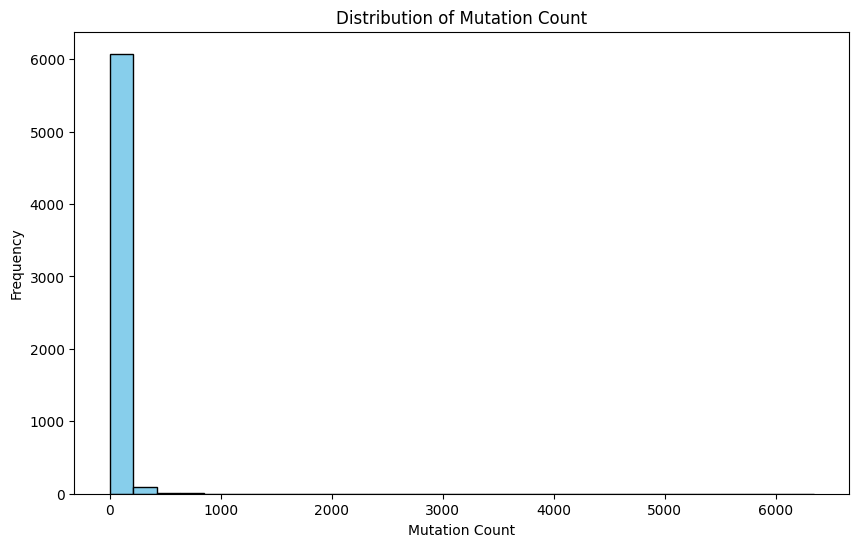

In [24]:
import matplotlib.pyplot as plt

# mutation_count 분포를 막대그래프로 시각화
plt.figure(figsize=(10, 6))
train['mutation_cnt'].plot(kind='hist', bins=30, color='skyblue', edgecolor='black')

# 그래프 제목 및 라벨 설정
plt.title('Distribution of Mutation Count')
plt.xlabel('Mutation Count')
plt.ylabel('Frequency')

# 그래프 출력
plt.show()

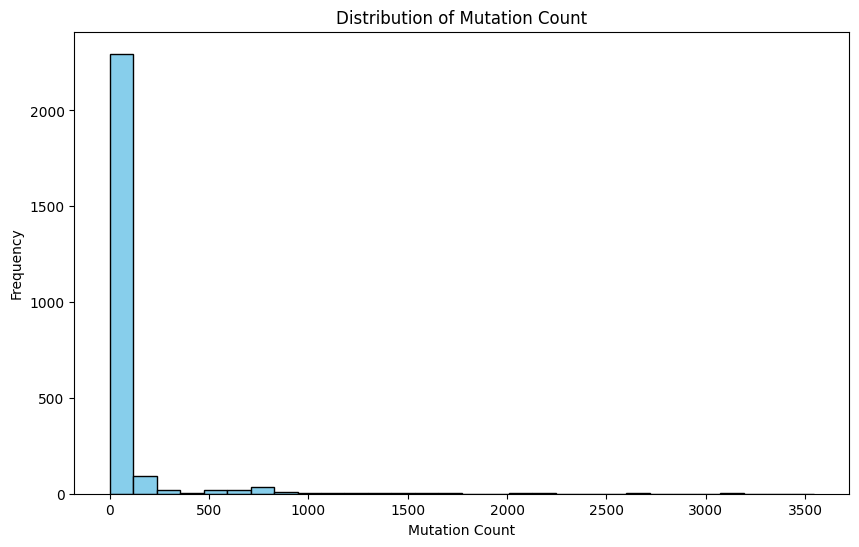

In [25]:
import matplotlib.pyplot as plt

# mutation_count 분포를 막대그래프로 시각화
plt.figure(figsize=(10, 6))
test['mutation_cnt'].plot(kind='hist', bins=30, color='skyblue', edgecolor='black')

# 그래프 제목 및 라벨 설정
plt.title('Distribution of Mutation Count')
plt.xlabel('Mutation Count')
plt.ylabel('Frequency')

# 그래프 출력
plt.show()

In [26]:
# SUBCLASS별 mutation_count의 평균 계산
train_mutation_count = pd.DataFrame(train.groupby('SUBCLASS')['mutation_cnt'].mean())
train_mutation_count.sort_values(by='mutation_cnt', ascending=True)

,mutation_cnt
SUBCLASS,
LAML,2.563291
PCPG,3.428571
THCA,3.435185
THYM,3.693878
PRAD,6.030075
LGG,7.109170
GBMLGG,9.904555
SARC,10.358586
KIRC,10.491018


### Custom Numeric Encoding (opt)

Nonsense > Frameshift > Delins > Deletion > Insertion > Missense > WT

In [ ]:
# 변이 유형에 대한 지수 값 정의
mutation_dict = {
    'WT': 10**0,
    'missense': 10**1,
    'insertion': 10**2,
    'deletion': 10**3,
    'delins': 10**4,
    'frameshift': 10**5,
    'nonsense': 10**6
}

# 변이 값을 합산하는 함수 정의
def mutation_to_numeric(value):
    # 문자열인지 확인
    if isinstance(value, str):
        # 공백만 있는 경우 처리
        if value.strip() == '':
            print("value.strip() doesn't work: ", value)
            return 0

        # 공백을 기준으로 변이 분리
        mutations = value.split()  # 공백을 기준으로 분리
        total_value = 0  # 합산 값 초기화

        # 각 변이 유형에 대해 반복
        for m in mutations:
            m = m.strip()  # 공백 제거
            if m in mutation_dict:
                total_value += mutation_dict[m]  # 사전에서 값을 찾아서 더함
         #   else:
         #       print(f"Unknown mutation type: {m}")  # 알 수 없는 변이 유형에 대해 출력

       # if total_value > 1:
       #     print(f"Total value for {value}: {total_value}\n")  # 디버깅 메시지

        return total_value
    else:
        print(value)
        return value  # 숫자나 다른 형식일 경우 그대로 반환


In [ ]:
# 함수 적용
for col in train.columns[2:]:  # ID 제외
    train[col] = train[col].apply(mutation_to_numeric)

In [ ]:
# 함수 적용
for col in test.columns[1:]:  # ID 제외
    test[col] = test[col].apply(mutation_to_numeric)

### Subclass_encoding (opt)

SUBCLASS
BRCA      786
KIPAN     515
GBMLGG    461
STES      379
KIRC      334
THCA      324
SKCM      276
PRAD      266
OV        253
LGG       229
HNSC      223
COAD      223
UCEC      198
SARC      198
LUAD      184
LUSC      178
LIHC      158
LAML      158
CESC      155
PCPG      147
TGCT      124
PAAD      120
BLCA      104
THYM       98
ACC        72
DLBC       38
Name: count, dtype: int64


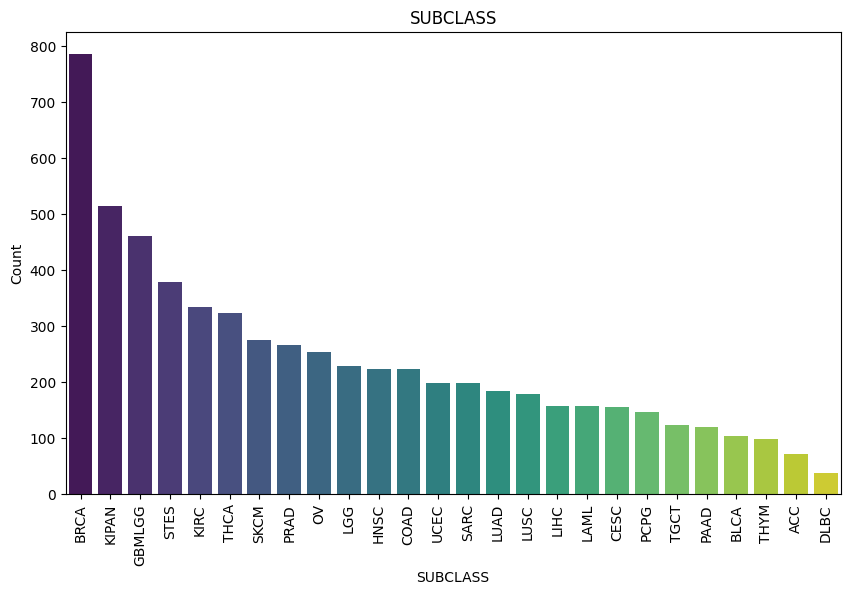

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# SUBCLASS 컬럼의 값 분포를 세는 코드
subclass_counts = train['SUBCLASS'].value_counts()

# 분포 출력
print(subclass_counts)

# 분포를 시각화하는 코드 (막대 그래프)
plt.figure(figsize=(10, 6))
sns.barplot(x=subclass_counts.index, y=subclass_counts.values, palette="viridis")
plt.xticks(rotation=90)
plt.title('SUBCLASS')
plt.xlabel('SUBCLASS')
plt.ylabel('Count')
plt.show()

#### LabelEncoder

In [52]:
# SUBCLASS 가 범주형이기 때문에 LabelEncoder 사용
le_subclass = LabelEncoder()
train['SUBCLASS'] = le_subclass.fit_transform(train['SUBCLASS'])

# 변환된 레이블 확인
for i, label in enumerate(le_subclass.classes_):
    print(f"원래 레이블: {label}, 변환된 숫자: {i}")

원래 레이블: ACC, 변환된 숫자: 0
원래 레이블: BLCA, 변환된 숫자: 1
원래 레이블: BRCA, 변환된 숫자: 2
원래 레이블: CESC, 변환된 숫자: 3
원래 레이블: COAD, 변환된 숫자: 4
원래 레이블: DLBC, 변환된 숫자: 5
원래 레이블: GBMLGG, 변환된 숫자: 6
원래 레이블: HNSC, 변환된 숫자: 7
원래 레이블: KIPAN, 변환된 숫자: 8
원래 레이블: KIRC, 변환된 숫자: 9
원래 레이블: LAML, 변환된 숫자: 10
원래 레이블: LGG, 변환된 숫자: 11
원래 레이블: LIHC, 변환된 숫자: 12
원래 레이블: LUAD, 변환된 숫자: 13
원래 레이블: LUSC, 변환된 숫자: 14
원래 레이블: OV, 변환된 숫자: 15
원래 레이블: PAAD, 변환된 숫자: 16
원래 레이블: PCPG, 변환된 숫자: 17
원래 레이블: PRAD, 변환된 숫자: 18
원래 레이블: SARC, 변환된 숫자: 19
원래 레이블: SKCM, 변환된 숫자: 20
원래 레이블: STES, 변환된 숫자: 21
원래 레이블: TGCT, 변환된 숫자: 22
원래 레이블: THCA, 변환된 숫자: 23
원래 레이블: THYM, 변환된 숫자: 24
원래 레이블: UCEC, 변환된 숫자: 25


# Model - XGBoost

In [53]:
# 범주형 변수를 찾기
cat_features_indices = train.select_dtypes(include=['object']).columns

# 범주형 변수의 인덱스 찾기
cat_feature_indices = [train.columns.get_loc(col) for col in cat_features_indices]

print("범주형 변수 인덱스:", cat_feature_indices)

범주형 변수 인덱스: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 

In [54]:
# 범주형 변수를 제외한 데이터프레임
non_cat_features = train.drop(columns=cat_features_indices)

# 범주형이 아닌 변수의 이름과 인덱스 출력
non_cat_features_indices = non_cat_features.columns
non_cat_feature_indices = [train.columns.get_loc(col) for col in non_cat_features_indices]

print("범주형이 아닌 변수 인덱스:", non_cat_feature_indices)
print("범주형이 아닌 변수 이름:", list(non_cat_features_indices))

범주형이 아닌 변수 인덱스: [1]
범주형이 아닌 변수 이름: ['SUBCLASS']


In [55]:
X = train.drop(columns=['SUBCLASS', 'ID'])
y = train['SUBCLASS']

from sklearn.feature_selection import SelectKBest, f_classif

# 예시 데이터프레임
X_encoded = pd.get_dummies(X)

# 상위 500개의 특성만 선택
selector = SelectKBest(score_func=f_classif, k=500)
X_new = selector.fit_transform(X_encoded, y)

# 선택된 특성의 인덱스 저장
selected_features_mask = selector.get_support()

In [56]:
selected_feature_names = X_encoded.columns[selected_features_mask]
print(selected_feature_names)

Index(['ABCA4_WT', 'ABCA8_WT', 'ABCA9_WT', 'ABCB1_WT', 'ABCB1_missense',
       'ABCB11_WT', 'ABCC3_WT', 'ABCC8_WT', 'ACACA_WT', 'ACSL5_WT',
       ...
       'VWF_missense missense missense missense', 'XCL1_missense missense',
       'XDH_WT', 'XDH_missense', 'XYLT2_WT', 'XYLT2_frameshift', 'ZEB1_WT',
       'ZFPM2_WT', 'ZFPM2_missense', 'ZNF292_WT'],
      dtype='object', length=500)


In [57]:
# _ 앞까지만 추출하고 중복 제거
unique_prefixes = sorted(set(name.split('_')[0] for name in selected_feature_names), reverse=False)

# 결과를 리스트로 변환
result = list(unique_prefixes)

# 결과 출력
print(result)

['ABCA4', 'ABCA8', 'ABCA9', 'ABCB1', 'ABCB11', 'ABCC3', 'ABCC8', 'ACACA', 'ACSL5', 'ACSM1', 'ACTN2', 'ADAM2', 'ADAMDEC1', 'ADCY1', 'ADCY2', 'AHNAK', 'AKAP13', 'ALB', 'ALMS1', 'ANGPT1', 'ANK1', 'APC', 'APOE', 'ARHGAP29', 'ARID5B', 'ARPP21', 'ATP1A3', 'ATRX', 'AVL9', 'B2M', 'BCL11B', 'BRAF', 'BRS3', 'BTG1', 'BTG2', 'C3', 'C8A', 'C8B', 'CACNA1A', 'CACNA1B', 'CACNA1F', 'CACNA1H', 'CAP2', 'CASP8', 'CD2', 'CD79B', 'CD86', 'CDCP1', 'CDH1', 'CDH11', 'CDH2', 'CDH4', 'CDH6', 'CDH8', 'CDKN1A', 'CDKN2A', 'CEBPA', 'CELSR1', 'CELSR2', 'CENPF', 'CFH', 'CFHR2', 'CFI', 'CFTR', 'CIITA', 'CLEC5A', 'CLGN', 'CLVS1', 'CNTN1', 'COL11A1', 'COL12A1', 'COL17A1', 'COL1A1', 'COL1A2', 'COL2A1', 'COL3A1', 'COL4A1', 'COL4A2', 'COL5A1', 'COL5A2', 'COL5A3', 'COL6A3', 'COL7A1', 'COL9A1', 'CR1', 'CR2', 'CREBBP', 'CTCF', 'CTNNB1', 'CTNND1', 'CYP2C18', 'CYP7B1', 'DCC', 'DDX60', 'DLC1', 'DMD', 'DOCK2', 'DPYD', 'DSC1', 'DSC2', 'DSC3', 'DST', 'DUSP2', 'DYNC1H1', 'EGFR', 'ELF3', 'ENPEP', 'EPHA2', 'EPHA5', 'EPHB2', 'ERBB3', 'E

In [58]:
# 원본 데이터프레임에서 선택된 특성만 추출
X_new_cat = X[result]

# 범주형 변수를 찾기
cat_features_indices = X_new_cat.select_dtypes(include=['object']).columns

# 범주형 변수의 인덱스 찾기
cat_feature_indices = [X_new_cat.columns.get_loc(col) for col in cat_features_indices]

print("범주형 변수 인덱스:", cat_feature_indices)

범주형 변수 인덱스: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 21

In [61]:
from sklearn.model_selection import train_test_split
# 데이터 분할
X_train, X_valid, y_train, y_valid = train_test_split(X_new_cat, y, test_size=0.2, random_state=42)

### 모델 학습

In [62]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 13.9 MB/s eta 0:00:00


In [63]:
from catboost import CatBoostClassifier, Pool

model = CatBoostClassifier(
    loss_function='MultiClass',
    custom_metric=['MultiClass', 'AUC', 'F1'],
    eval_metric = 'MultiClass',

    iterations=1000,
    learning_rate=0.1,
    random_seed=42,

    depth=6,
    grow_policy='Depthwise',
    auto_class_weights='SqrtBalanced',
    cat_features=cat_feature_indices,  # 범주형 특징 인덱스


    verbose=True,
    early_stopping_rounds=50,
    task_type="GPU"
)

# 모델 학습
model.fit(X_train, y_train,
          eval_set=(X_valid, y_valid))


# 최적 모델 저장
model.save_model('best_model.cbm')

Default metric period is 5 because AUC is/are not implemented for GPU
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
AUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 3.0576395	test: 3.0796044	best: 3.0796044 (0)	total: 674ms	remaining: 11m 13s
1:	total: 929ms	remaining: 7m 43s
2:	total: 1.2s	remaining: 6m 39s
3:	total: 1.48s	remaining: 6m 8s
4:	total: 1.81s	remaining: 6m
5:	learn: 2.7538117	test: 2.8102859	best: 2.8102859 (5)	total: 2.75s	remaining: 7m 36s
6:	total: 3.04s	remaining: 7m 10s
7:	total: 3.31s	remaining: 6m 50s
8:	total: 3.5s	remaining: 6m 25s
9:	total: 3.77s	remaining: 6m 12s
10:	learn: 2.6133996	test: 2.6835905	best: 2.6835905 (10)	total: 4.69s	remaining: 7m 2s
11:	total: 4.89s	remaining: 6m 42s
12:	total: 4.99s	remaining: 6m 18s
13:	total: 5.08s	remaining: 5m 57s
14:	total: 5.16s	remaining: 5m 39s
15:	learn: 2.5149471	test: 2.6003635	best: 2.6003635 (15)	total: 5.48s	remaining: 5m 36s
16:	total: 5.59s	remaining: 5m 23s
17:	total: 5.73s	remaining: 5m 12s
18:	total: 5.88s	remaining: 5m 3s
19:	total: 6.03s	remaining: 4m 55s
20:	learn: 2.4582231	test: 2.5541089	best: 2.5541089 (20)	total: 6.5s	remaining: 5m 2s
21:	total: 6.54s	

In [64]:
X_test = test.drop(columns=['ID'])

X_test_cat = X_test[result]

# 저장된 모델 불러오기
loaded_model = CatBoostClassifier()
loaded_model.load_model('best_model.cbm')

# 예측 수행
predictions = loaded_model.predict(X_test_cat)
original_labels = le_subclass.inverse_transform(predictions)

submission["SUBCLASS"] = original_labels
submission.to_csv('./CAT_submission_base.csv', encoding='UTF-8-sig', index=False)

In [ ]:
'''importance = loaded_model.feature_importances_
feature_importance = pd.DataFrame({'Feature': pd.DataFrame(X_train).columns, 'Importance': importance})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print(len(feature_importance), len(feature_importance[feature_importance.Importance > 0.0]))'''

1500 1499
